# Peer-graded Assignment: Capstone Project Peer Review - My Solutions

The following questions (tasks) are being evaluated as part of the peer review submission:
1. Are there unit tests for the API?
2. Are there unit tests for the model?
3. Are there unit tests for the logging?
4. Can all of the unit tests be run with a single script and do all of the unit tests pass?
5. Is there a mechanism to monitor performance?
6. Was there an attempt to isolate the read/write unit tests from production models and logs?
7. Does the API work as expected? For example, can you get predictions for a specific country as well as for all countries combined?
8. Does the data ingestion exists as a function or script to facilitate automation?
9. Were multiple models compared?
10. Did the EDA investigation use visualizations?
11. Is everything containerized within a working Docker image?
12. Did they use a visualization to compare their model to the baseline model? 

### Start Flask Server with following bash command

```
~$ python app.py
```

### Then access http://0.0.0.0:8080/ to see the webside

## Import Library

In [11]:
import os
import sys
import csv
import requests
from collections import Counter
from datetime import date
from ast import literal_eval
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## TASK 1: Unit Test for API 

In [5]:
!python ./unittests/ApiTests.py

....
----------------------------------------------------------------------
Ran 4 tests in 4.176s

OK


## TASK 2: Units test for model

In [7]:
!python ./unittests/ModelTests.py

... grid searching
... saving test version of model
.... loading test version of model
.... loading test version of model
.
----------------------------------------------------------------------
Ran 3 tests in 3.999s

OK


## TASK 3: Units test for logging

In [6]:
!python ./unittests/LoggerTests.py

....
----------------------------------------------------------------------
Ran 4 tests in 0.006s

OK


## TASK 4: Run all of the unit tests with a single script and pass

In [8]:
!python run-tests.py

........... grid searching
... saving test version of model
.... loading test version of model
.... loading test version of model
.
----------------------------------------------------------------------
Ran 11 tests in 5.350s

OK


In [15]:
r = requests.get('http://127.0.0.1:8080/logs/train-test.log')
print(r.text)

unique_id,timestamp,x_shape,eval_test,model_version,model_version_note,runtime
eda70fda-cc75-4731-bf02-ca63655c7a27,1609248718.196655,"(100, 10)",{'rmse': 0.5},0.1,test model,00:00:01
d31de585-374c-4ddf-b088-cd5b19424fc1,1609248718.196876,"(100, 10)",{'rmse': 0.5},0.1,test model,00:00:01
16f26ce1-69fb-429c-b8fb-20563be6af4f,1609248722.012531,"(900, 4)","{'0.0': {'precision': 0.8277310924369747, 'recall': 0.9120370370370371, 'f1-score': 0.86784140969163, 'support': 216}, '1.0': {'precision': 0.6779661016949152, 'recall': 0.49382716049382713, 'f1-score': 0.5714285714285714, 'support': 81}, 'accuracy': 0.797979797979798, 'macro avg': {'precision': 0.752848597065945, 'recall': 0.7029320987654322, 'f1-score': 0.7196349905601007, 'support': 297}, 'weighted avg': {'precision': 0.7868860949618676, 'recall': 0.797979797979798, 'f1-score': 0.7870015447107959, 'support': 297}}",0.1,RF on AAVAIL churn,000:00:03



## TASK 5: Monitor performance

* Train model

In [9]:
!python run-model-train.py

... grid searching
... saving model: models/model-0_1.joblib
... saving latest data
model training complete.


* Monitor Performance

(61, 4)
logs/predict-2020-12.log
[(0.0, 48), (1.0, 13)]
(61, 4)
OUTLIER TEST FAILED: 8.2 >= 2.1
DISTRIBUTION X TEST FAILED: 0.27 >= 0.02
DISTRIBUTION y TEST FAILED: 0.08 >= 0.04


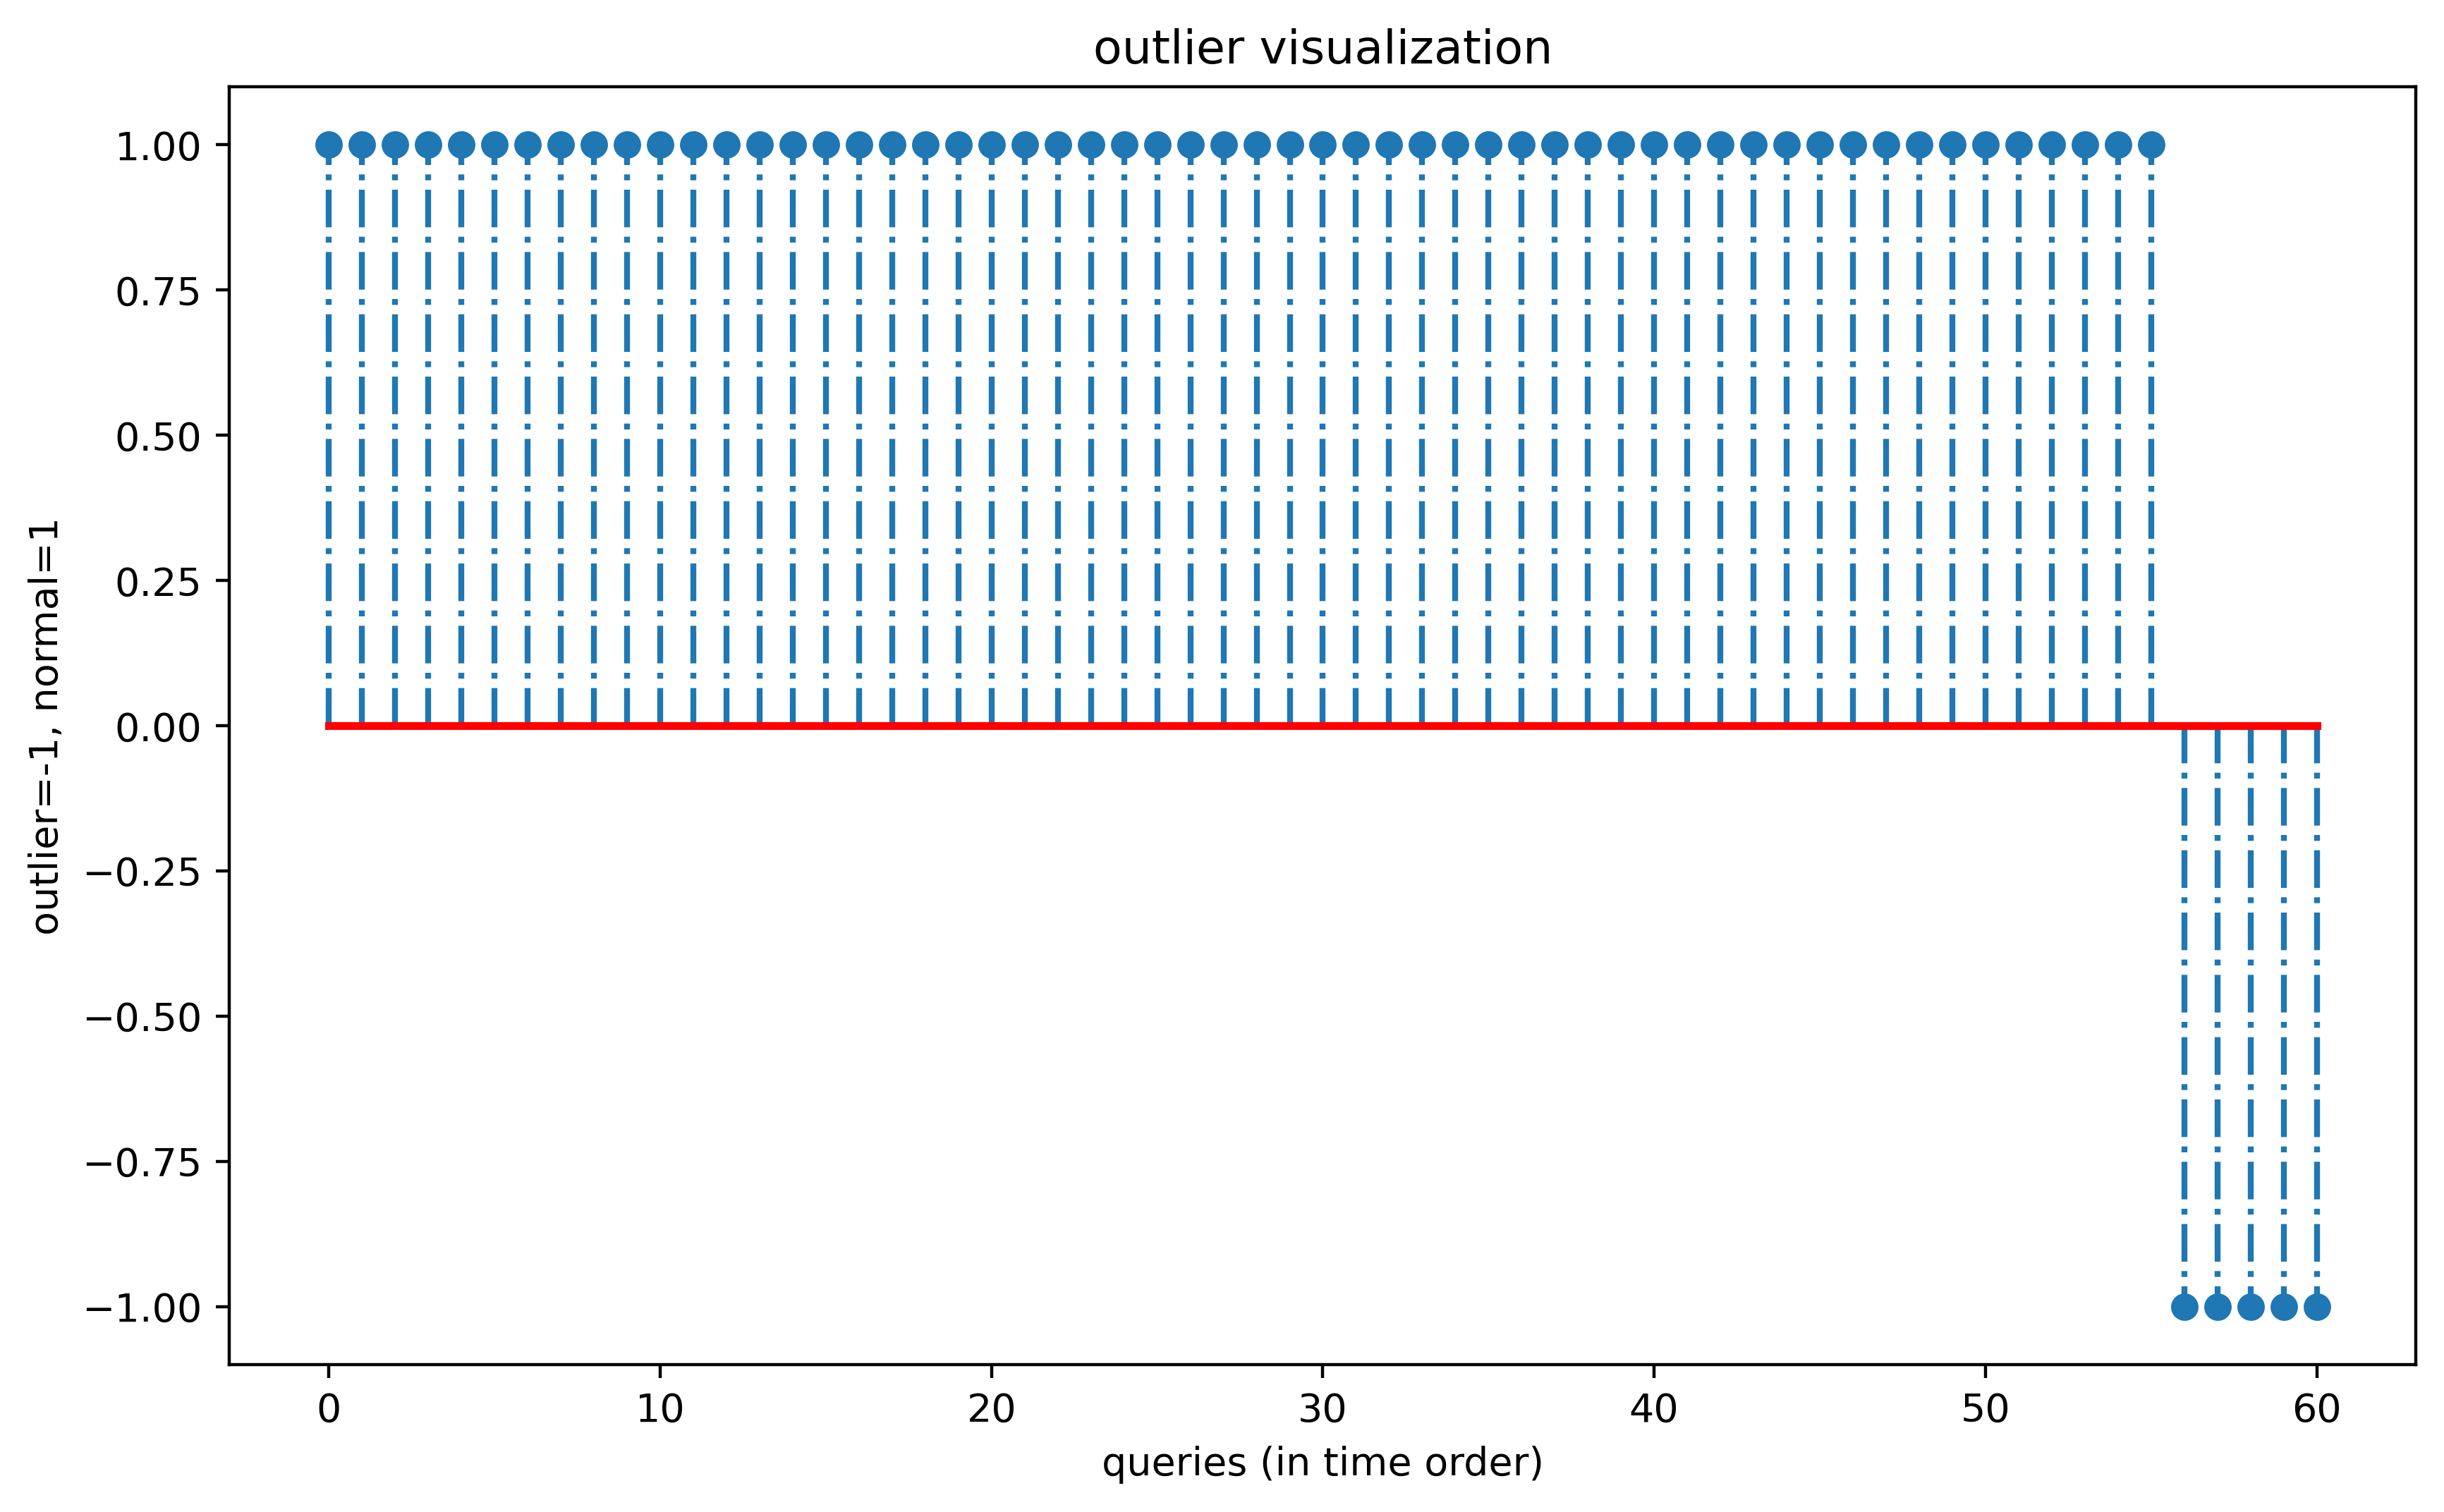

In [12]:
from monitoring import get_latest_train_data, get_monitoring_tools

## load latest data
data = get_latest_train_data()
y = data['y']
X = data['X']

## generate some data
bs_samples = 60
subset_indices = np.random.choice(np.arange(X.shape[0]),
                                  bs_samples,replace=True).astype(int)
mask = np.in1d(np.arange(X.shape[0]), subset_indices)
X_bs=X[mask]
X_outliers = X[:5].copy()
X_outliers['age'] = [88, 90, 76, 80, 68]
X_outliers['num_streams'] = [111, 100, 80, 90, 150]
X_query = pd.concat([X_bs, X_outliers])

print(X_query.shape)

## delete the log file so we are starting fresh
today = date.today() 
logfile = os.path.join("logs", "predict-{}-{}.log".format(today.year, today.month)) 
print(logfile)
if os.path.exists(logfile):
    os.remove(logfile)

## ping the API
request_json = {'query':X_query.to_dict(), 'type':'dict'}
port = 8080
r = requests.post('http://127.0.0.1:{}/predict'.format(port), json=request_json)
response = literal_eval(r.text)
print(list(sorted(Counter(response['y_pred']).items())))

## Monitor Performance
pm_tools = get_monitoring_tools(X, y)

## read in the logged data
df = pd.read_csv(logfile)
df.drop(columns=["unique_id","y_proba"], inplace=True)
df.head()

## reconstruct a data frame from the logged queries
queries = [literal_eval(q) for q in df['query'].values]
queries = pd.DataFrame(queries)
queries.columns = ['country', 'age', 'subscriber_type', 'num_streams']
print(queries.shape)
queries.head()

from scipy.stats import wasserstein_distance
X_target = pm_tools['preprocessor'].transform(queries)

outlier_test = pm_tools['clf_X'].predict(X_target)
outliers_X = 100 * (1.0 - (outlier_test[outlier_test==1].size / outlier_test.size))
wasserstein_X = wasserstein_distance(pm_tools['X_source'].flatten(), X_target.flatten()) 
wasserstein_y = wasserstein_distance(pm_tools['y_source'], df['y_pred'].values)

if outliers_X >= pm_tools['outlier_X']:
    print("OUTLIER TEST FAILED: {} >= {}".format(round(outliers_X,2),
                                                 pm_tools['outlier_X']))
else:
    print("OUTLIER TEST PASSED: {} < {}".format(round(outliers_X,2),
                                                pm_tools['outlier_X']))
    
if wasserstein_X >= pm_tools['wasserstein_X']:
    print("DISTRIBUTION X TEST FAILED: {} >= {}".format(round(wasserstein_X,2),
                                                        pm_tools['wasserstein_X']))
else:
    print("DISTRIBUTION X TEST PASSED: {} < {}".format(round(wasserstein_X),
                                                       pm_tools['wasserstein_X']))
    
if wasserstein_y >= pm_tools['wasserstein_y']:
    print("DISTRIBUTION y TEST FAILED: {} >= {}".format(round(wasserstein_y,2),
                                                        pm_tools['wasserstein_y']))
else:
    print("DISTRIBUTION y TEST PASSED: {} < {}".format(round(wasserstein_y),
                                                       pm_tools['wasserstein_y']))

fig = plt.figure(figsize=(10,6),dpi=400)
ax = fig.add_subplot(111)

x_range = np.arange(outlier_test.size)
labels = ['outlier','normal']
markerline, stemlines, baseline = ax.stem(x_range, outlier_test, '-.',
                                          use_line_collection=True)
plt.setp(baseline, 'color', 'r', 'linewidth', 2)
ax.set_title("outlier visualization")
ax.set_ylabel("outlier=-1, normal=1")
ax.set_xlabel("queries (in time order)");


## Question 6: Was there an attempt to isolate the read/write unit tests from production models and logs?

### Answer 6: 
* Read unit test of models:
    * unittests/ModelTests.test_02_load()
* Write Unit test of models:
    * unittests/ModelTests.test_01_train()
* Read unit test of logs:
    * unittests/LoggerTests.test_03_predict()
* Write Unit test of logs:
    * unittests/LoggerTests.test_01_train()    

## Question 7: Does the API work as expected? For example, can you get predictions for a specific country as well as for all countries combined?

In [23]:
from model import *

port = 8080

## load model first
model = model_load(test=True)

## ensure that a list can be passed
query = {'country': ['united_states'],
         'age': [24],
         'subscriber_type': ['aavail_basic'],
         'num_streams': [8]
}

# result = model_predict(query, model, test=True)
# y_pred = result['y_pred']

# print("y_pred = ", y_pred)

query_type = 'dict'
request_json = {'query':query, 'type':query_type, 'mode':'test'}

r = requests.post('http://127.0.0.1:{}/predict'.format(port), json=request_json)
response = literal_eval(r.text)
print("response = ", response)

... loading test version of model
response =  {'y_pred': [0.0], 'y_proba': 'None'}


## Question 8: Does the data ingestion exists as a function or script to facilitate automation?

### Answer 8: 
* Data ingestion function:
    * model.load_aavail_data()

## Question 9: Were multiple models compared?

## Question 10: Did the EDA investigation use visualizations?

### Answer 10: 
* Please See Aavail_EDA.ipynb

## TASK 11: Build with Docker Image

```
~$ docker build -t aavail-ml .
~$ docker run -p 4000:8080 aavail-ml

```

### Then access http://0.0.0.0:4000/ to see the webside

## Question 12: Did they use a visualization to compare their model to the baseline model? 